This tutorial measures the runtime of Global Effect plots, which is mainly influenced by the following factors:

- $t_f$: The runtime of the underlying black-box function, i.e., how much time it takes to apply $f$ on the whole dataset
- $N$: The number of instances, `X = (N,D)`
- $D$: The number of features, `X = (N,D)`
- $T$: The number of points used for centering the feature effect plot.
- $M$: The number of evaluation points

In this tutorial, we'll focus on $t_f$, $N$, and $D$ to measure how each influences the runtime of Global PDP.

In [1]:
import effector
import numpy as np
import timeit
import time
import matplotlib.pyplot as plt
np.random.seed(21)

In [2]:
def return_predict(t):
    def predict(x):
        time.sleep(t)
        model = effector.models.DoubleConditionalInteraction()
        return model.predict(x)
    return predict

def return_jacobian(t):
    def jacobian(x):
        time.sleep(t)
        model = effector.models.DoubleConditionalInteraction()
        return model.jacobian(x)
    return jacobian

In [26]:
def measure_time(method_name, features):
    fit_time_list, eval_time_list = [], []
    X = np.random.uniform(-1, 1, (N, D))
    xx = np.linspace(-1, 1, M)
    axis_limits = np.array([[-1] * D, [1] * D])

    method_map = {
        "pdp": effector.PDP,
        "d_pdp": effector.DerPDP,
        "ale": effector.ALE,
        "rhale": effector.RHALE,
        "shap_dp": effector.ShapDP
    }

    for _ in range(repetitions):
        # general kwargs
        method_kwargs = {"data": X, "model": model, "axis_limits": axis_limits}
        fit_kwargs = {"features": features, "centering": True, "points_for_centering": T}

        # specialize kwargs per method
        if method_name in ["d_pdp", "rhale"]:
            method_kwargs["model_jac"] = model_jac
        if method_name in ["rhale", "ale"]:
            fit_kwargs["binning_method"] = effector.binning_methods.Fixed(nof_bins=20)

        # init
        method = method_map[method_name](**method_kwargs)

        # fit
        tic = time.time()
        method.fit(**fit_kwargs)
        fit_time_list.append(time.time() - tic)

        # eval
        tic = time.time()
        for feat in features:
            eval_kwargs = {"feature": feat, "xs": xx, "centering": True, "heterogeneity": True}
            method.eval(**eval_kwargs)
        eval_time_list.append(time.time() - tic)

    return {"fit": np.mean(fit_time_list), "eval": np.mean(eval_time_list), "total": (np.mean(fit_time_list) + np.mean(eval_time_list))}

In [27]:
import matplotlib.pyplot as plt

def bar_plot(xs, time_dict, methods, metric, title, xlabel, ylabel, bar_width=0.02):

    bar_width = (np.max(xs) - np.min(xs)) / 40
    method_to_label = {"ale": "ALE", "rhale": "RHALE", "pdp": "PDP", "d_pdp": "d-pdp", "shap_dp": "SHAP DP"}
    plt.figure()
    
    # Calculate the offsets for each bar group
    offsets = np.linspace(-2*bar_width, 2*bar_width, len(methods))
    
    for i, method in enumerate(methods):
        label = method_to_label[method]
        plt.bar(
            xs + offsets[i],
            [tt[metric] for tt in time_dict[method]],
            label=label,
            width=bar_width
        )
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

## Global methods vs $t_f$

In [28]:
t = 0.001
N = 100_000
D = 30
T = 100
M = 100
repetitions = 2
features=[0]

In [29]:
method_names = ["ale", "rhale", "pdp", "d_pdp"]
vec = np.array([.1, .5, 1.])
time_dict = {method_name: [] for method_name in method_names}
for t in vec:
    model = return_predict(t)
    model_jac = return_jacobian(t)
    for method_name in method_names:
        time_dict[method_name].append(measure_time(method_name, features))

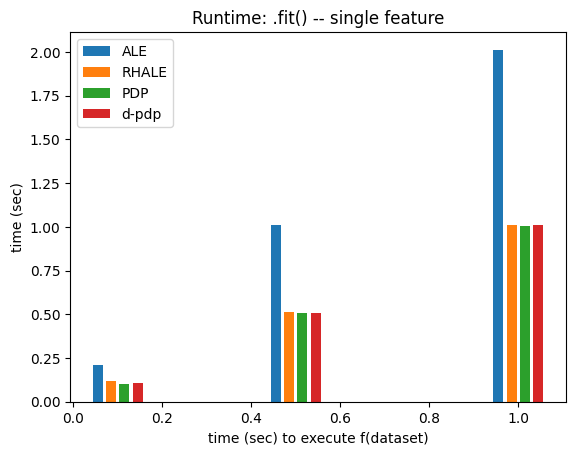

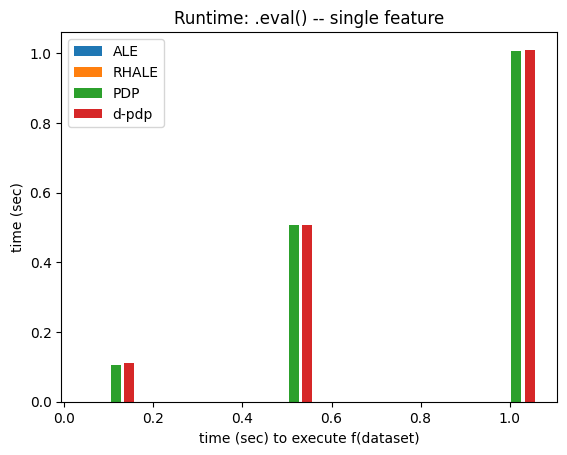

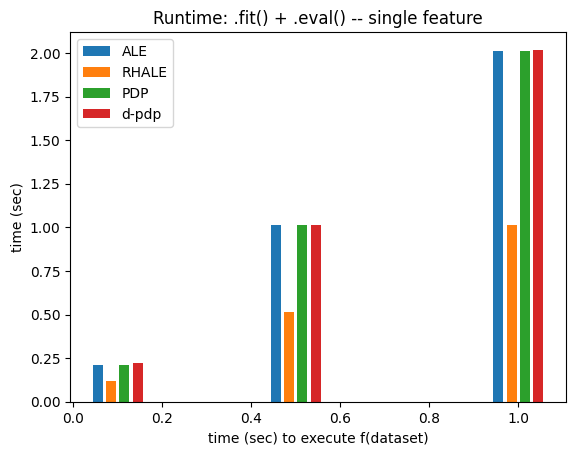

In [34]:
for metric in ["fit", "eval", "total"]:
    if metric in ["fit", "eval"]:
        title = "Runtime: ." + metric + "() -- single feature"
    else:
        title = "Runtime: .fit() + .eval() -- single feature"
    
    bar_plot(
        vec, 
        time_dict, 
        method_names,
        metric=metric,
        title=title,
        xlabel="time (sec) to execute f(dataset)",
        ylabel="time (sec)"
)

### Comparison

| Method        | `.fit()`     | `.eval()` -- one time | `.eval()` -- $l$ times | Total cost for $l$ evaluations     |
|---------------|--------------|-----------------------|------------------------|------------------------------------|
| **PDP / d-PDP** | $t_f$       | $t_f$                | $l t_f$                | $(1 + l) t_f$                      |
| **ALE**       | $2t_f$       | Free                  | Free                   | $2t_f$                             |
| **RHALE**     | $t_f$        | Free                  | Free                   | $t_f$                              |

## Time for fitting all features 

In [35]:
t = 0.1
N = 100_000
D = 30
T = 100
M = 100
repetitions = 2
features=[0]

In [36]:
method_names = ["ale", "rhale", "pdp", "d_pdp"]
vec = np.array([3, 4, 5, 6])
time_dict = {method_name: [] for method_name in method_names}
for D in vec:
    features = [dd for dd in range(D)]
    model = return_predict(t)
    model_jac = return_jacobian(t)
    for method_name in method_names:
        time_dict[method_name].append(measure_time(method_name, features))

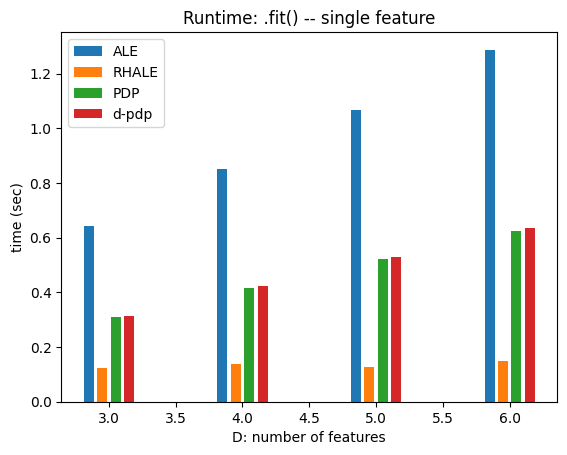

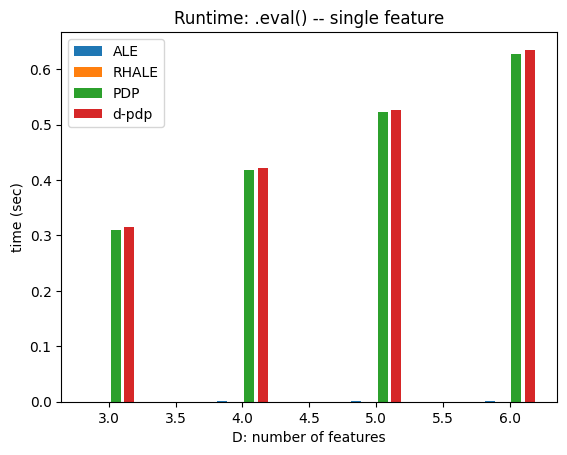

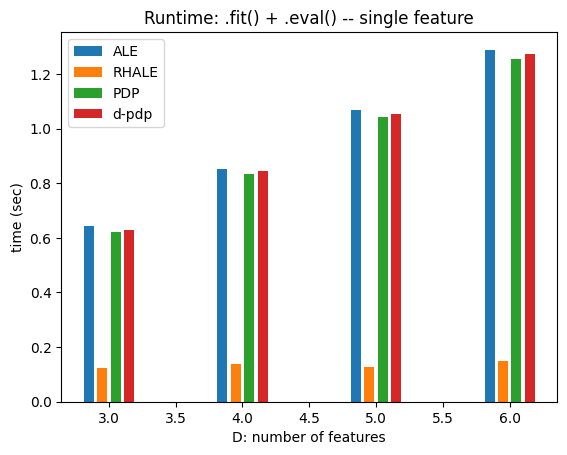

In [37]:
for metric in ["fit", "eval", "total"]:
    if metric in ["fit", "eval"]:
        title = "Runtime: ." + metric + "() -- single feature"
    else:
        title = "Runtime: .fit() + .eval() -- single feature"
    
    bar_plot(
        vec, 
        time_dict, 
        method_names,
        metric=metric,
        title=title,
        xlabel="D: number of features",
        ylabel="time (sec)"
)

## PDP time vs N (number of features)

In [15]:
t = 0.1
N = 100_000
D = 30
T = 100
M = 100
repetitions = 2
features=[0]

In [16]:
method_names = ["ale", "rhale", "pdp", "d_pdp"]
vec = np.array([50_000, 100_000, 150_000, 200_000])
time_dict = {method_name: [] for method_name in method_names}
for N in vec:
    model = return_predict(t)
    model_jac = return_jacobian(t)
    for method_name in method_names:
        time_dict[method_name].append(measure_time(method_name, features))

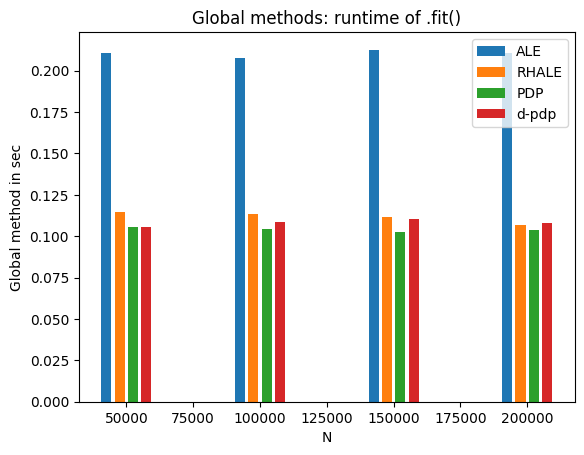

In [17]:
bar_plot(
    vec, 
    time_dict, 
    method_names,
    metric="fit",
    title="Global methods: runtime of .fit()",
    xlabel="N",
    ylabel="Global method in sec"
)

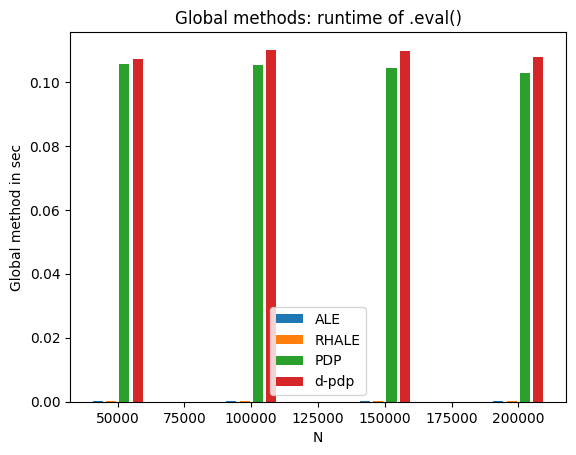

In [18]:
bar_plot(
    vec, 
    time_dict, 
    method_names,
    metric="eval",
    title="Global methods: runtime of .eval()",
    xlabel="N",
    ylabel="Global method in sec"
)

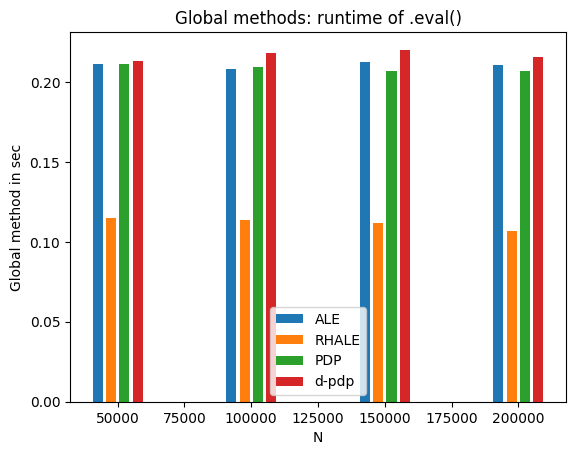

In [19]:
bar_plot(
    vec, 
    time_dict, 
    method_names,
    metric="total",
    title="Global methods: runtime of .eval()",
    xlabel="N",
    ylabel="Global method in sec"
)

## Conclusion

In practice, the vectorized version outperforms the non-vectorized version in all cases:

- The runtime of the black-box model is the key factor. As the model size increases, the non-vectorized implementation shows a linear increase in runtime, while the vectorized implementation remains unaffected.
- The number of instances does not significantly impact the runtime for either version, as long as \( y \) can be obtained in a single pass of \( f(x) \).
- Both versions scale linearly with the number of features, but the vectorized version is consistently faster by a constant margin.